In [1]:
DATA_PATH = '../QuMaDe1/data/out2'
MODEL_NAME = "model_on_80x80"
STATS_PATH = "./Models"
LIB_PATH = "."

#fgbg_images : 
fgbgmean = (0.43703552,0.43865393,0.42539937)#Calculated for this data
fgbgstd = (0.28416609,0.25724655,0.25717132)

#mask_images :
maskmean = (0.03939557,)
maskstd =  (0.19311964,)

#depth_images : 
depthmean = (0.55656881, )
depthstd =  (0.26315377,)

#size = (128,128)
size = (80,80)

In [2]:
import sys
sys.path.append(f"{LIB_PATH}/EVALibrary")
sys.path.append(f"{LIB_PATH}/EVALibrary/EVA4")
sys.path.append(f"{LIB_PATH}/EVALibrary/EVA4/eva4models")


import warnings
warnings.filterwarnings("ignore")
import random
from tqdm.notebook import tqdm, trange
import os
import gc
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import transforms
from matplotlib import pyplot as plt
import torchvision
import torch
from torch import nn
from utils import prepareData, displayData, show
from CustomData import CustomDataset




In [3]:
!pip install torchsummary
from torchsummary import summary

Defaulting to user installation because normal site-packages is not writeable


In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [5]:
#Create directory of logs
logs_base_dir = "runs"
os.makedirs(logs_base_dir, exist_ok=True)

In [6]:
data = prepareData(DATA_PATH)

In [7]:
data = data[:5000]   #for testing everything is running or not
print('Dataset size :',len(data))
trainlen = int(len(data)*0.7)
print("Train set : ", trainlen)
print("Test set : ", len(data)-trainlen)
print("Sample Record in the data set.... Contains paths to bg, fgbg, mask and depth")
print(data[0])
#print(data[399999])

Dataset size : 5000
Train set :  3500
Test set :  1500
Sample Record in the data set.... Contains paths to bg, fgbg, mask and depth
('../QuMaDe1/data/out2/images/fgbg252808.jpg', '../QuMaDe1/data/out2/masks/mask252808.jpg', '../QuMaDe1/data/out2/depth/fgbg252808.jpg')


(224, 224) (224, 224) (224, 224)


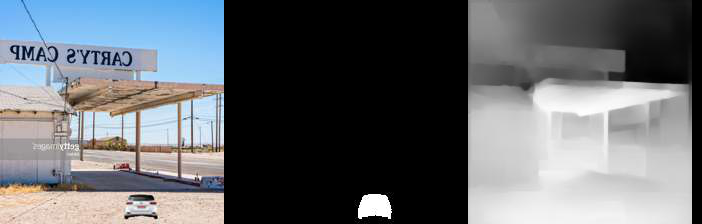

In [8]:
#Samplerecord display
displayData(data, 456)

In [9]:
import numpy as np
from eva4datatransforms import AlbumentationTransforms
import albumentations as A

 


fgbg_transforms = transforms.Compose([
         transforms.Resize(size),
         #transforms.RandomHorizontalFlip(),
         transforms.RandomRotation((-4, 4)),
         transforms.RandomGrayscale(p=0.05),
         transforms.ColorJitter(brightness=0.15, contrast=0.08, saturation=0.08, hue=0.08),
         transforms.ToTensor(),
         transforms.Normalize(fgbgmean, fgbgstd)                              
])


test_fgbgtransforms = transforms.Compose([
         transforms.Resize(size),
         transforms.ToTensor(),
         transforms.Normalize(fgbgmean, fgbgstd)                              
])

mask_transforms = transforms.Compose([
         transforms.Resize(size),
         transforms.ToTensor(),
         #transforms.Normalize(maskmean, maskstd)                              
])

depth_transforms = transforms.Compose([
         transforms.Resize(size),
         transforms.ToTensor(),
         #transforms.Normalize(depthmean, depthstd)                              
])

In [10]:
train = CustomDataset(data[:trainlen],  fgbg_transforms, mask_transforms, depth_transforms)
test = CustomDataset(data[trainlen:], test_fgbgtransforms, mask_transforms, depth_transforms)
print(len(train), len(test))

3500 1500


In [11]:
import eva4dataloaders
batch_size=64

dataloader = eva4dataloaders.DataLoader(batch_size=batch_size, shuffle=True)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

In [12]:
[(k, v.shape) for k, v in train[0].items()]

[('fgbg', torch.Size([3, 80, 80])),
 ('mask', torch.Size([1, 80, 80])),
 ('depth', torch.Size([1, 80, 80]))]

In [13]:
sample = next(iter(train_loader))
totalbatches = len(train_loader)
print('No.of batches :', totalbatches, 'Every sample contains :', len(sample))

No.of batches : 55 Every sample contains : 3


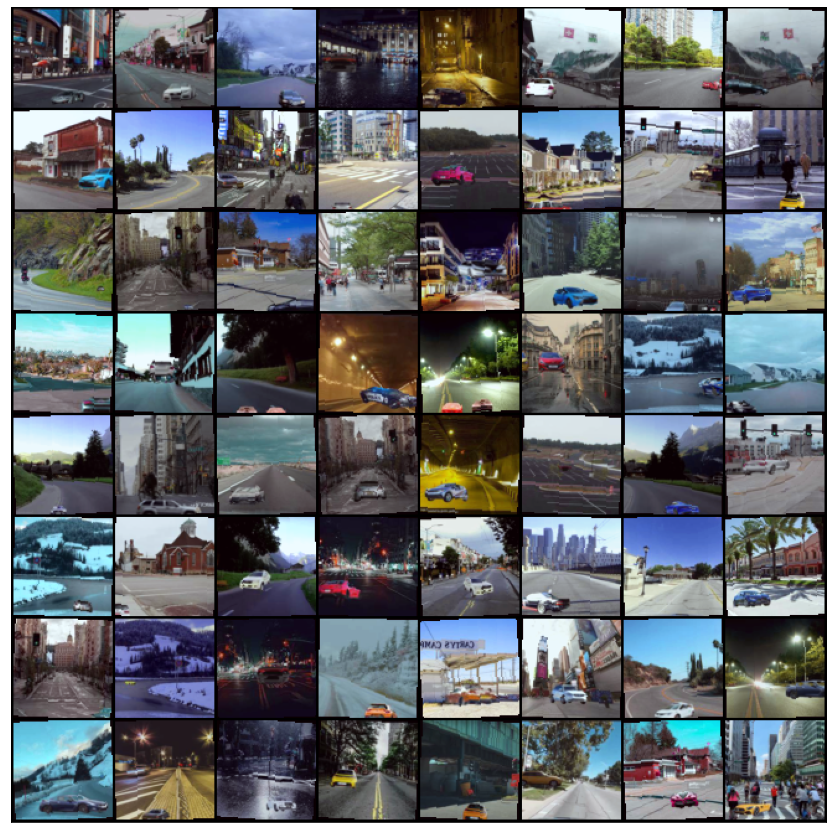

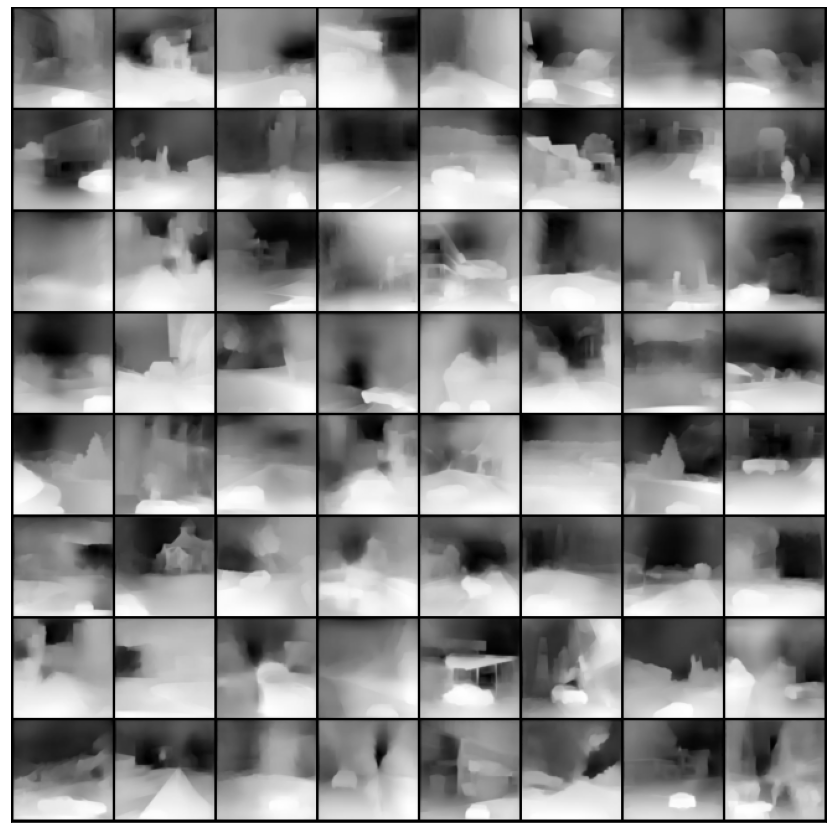

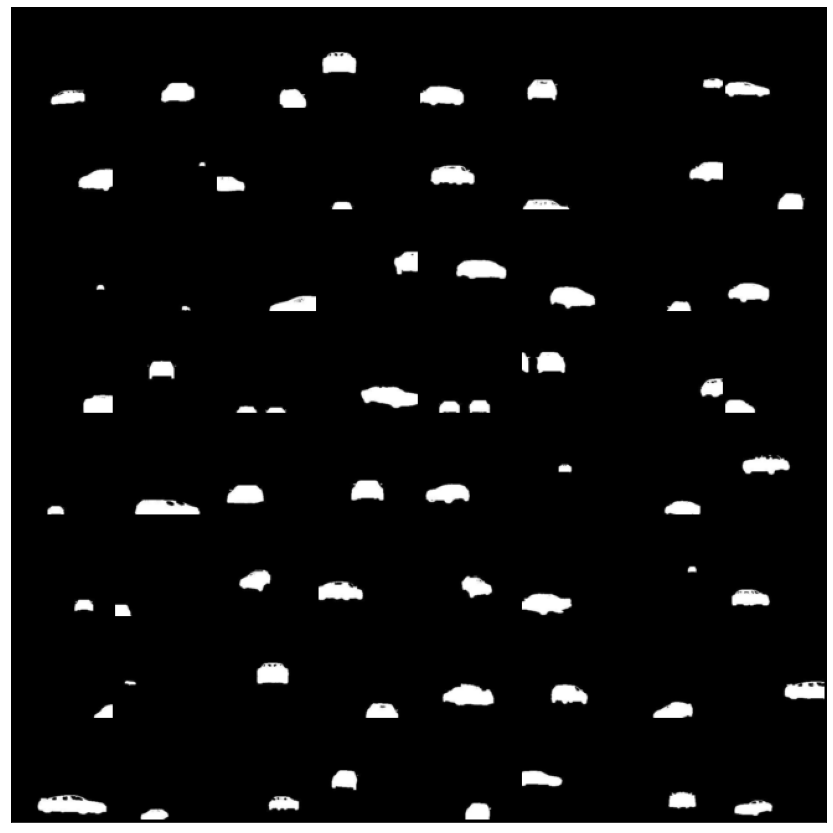

In [14]:
show(sample['fgbg'], normalize=True)
show(sample['depth'])
show(sample['mask'])

In [15]:
# Give a name to the model...
# This helps in saving the model and quantitative results for training as  well as testing data
name = MODEL_NAME

In [16]:
#from eva4models.eva4resnet import ResNet18
from loss import ssim
from lightmodel import S15Model
model = S15Model(name)
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary(input_size=((3,224,224)))

Model parameters initialized
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 64, 112, 112]          18,432
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              ReLU-6         [-1, 64, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]           4,096
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]             576
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13         [-1, 64, 112, 112]           4,096
      Batc

Initial LR-  [0.009999999999999995]
Total steps -  560


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]


0it [00:00, ?it/s]
Batch=1 Loss=1.4027 LR=0.010000: : 0it [00:04, ?it/s]
Batch=1 Loss=1.4027 LR=0.010000: : 1it [00:04,  4.02s/it]
Batch=2 Loss=1.3930 LR=0.010008: : 1it [00:04,  4.02s/it]
Batch=2 Loss=1.3930 LR=0.010008: : 2it [00:04,  1.83s/it]
Batch=3 Loss=1.3742 LR=0.010032: : 2it [00:04,  1.83s/it]
Batch=3 Loss=1.3742 LR=0.010032: : 3it [00:04,  1.13s/it]
Batch=4 Loss=1.3472 LR=0.010072: : 3it [00:04,  1.13s/it]
Batch=4 Loss=1.3472 LR=0.010072: : 4it [00:04,  1.26it/s]
Batch=5 Loss=1.3269 LR=0.010127: : 4it [00:07,  1.26it/s]
Batch=5 Loss=1.3269 LR=0.010127: : 5it [00:07,  1.42s/it]
Batch=6 Loss=1.3143 LR=0.010199: : 5it [00:07,  1.42s/it]
Batch=6 Loss=1.3143 LR=0.010199: : 6it [00:07,  1.05s/it]
Batch=7 Loss=1.3000 LR=0.010286: : 6it [00:08,  1.05s/it]
Batch=7 Loss=1.3000 LR=0.010286: : 7it [00:08,  1.25it/s]
Batch=8 Loss=1.3016 LR=0.010390: : 7it [00:08,  1.25it/s]
Batch=8 Loss=1.3016 LR=0.010390: : 8it [00:08,  1.57it/s]
Batch=9 Loss=1.2771 LR=0.010509: : 8it [00:10,  1.57it/s

0.0 1.0
1e-05 1.00001 1e-05 1.00001
0.0 1.0
1e-05 1.00001 1e-05 1.00001
train Quantitative measures (a1, a2, a3, abs_rel, rmse, log_10)  1.mask 2.depth
0.0558978125 0.0783153125 0.0973896875 14051.119 0.36093175 2.388235
0.28840834821428574 0.45384232142857145 0.5629610267857142 4.542472 0.35557568 0.6183247



0it [00:00, ?it/s]

First batch in testing fgbg, (mask, predicted mask), (depth, predicted depth)


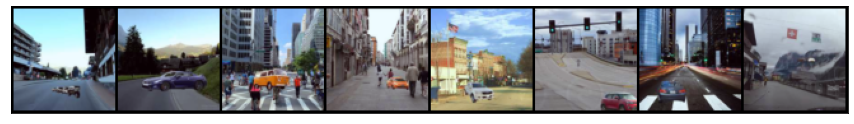

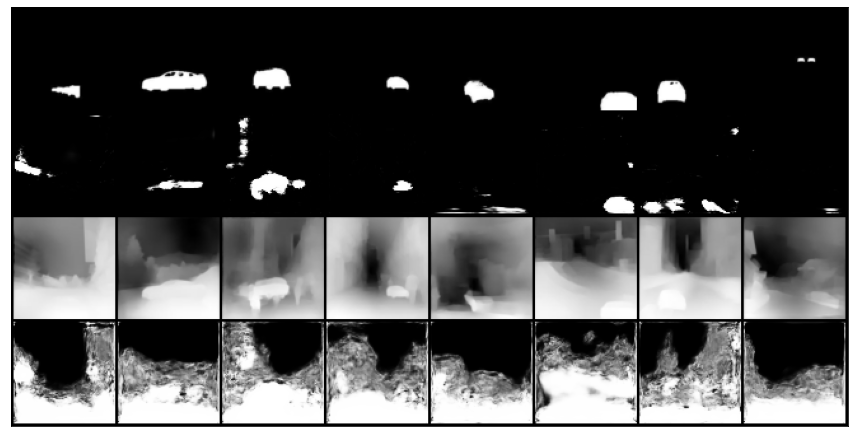


1it [00:22, 22.84s/it]
2it [00:22,  9.47s/it]
3it [00:23,  5.19s/it]
5it [00:26,  3.17s/it]
6it [00:26,  2.29s/it]
7it [00:26,  1.77s/it]
9it [00:30,  1.74s/it]
10it [00:30,  1.34s/it]
11it [00:30,  1.10s/it]
12it [00:30,  1.21it/s]
13it [00:34,  1.49s/it]
14it [00:34,  1.10s/it]
15it [00:34,  1.19it/s]
17it [00:38,  1.27s/it]
18it [00:38,  1.01it/s]
19it [00:38,  1.24it/s]
20it [00:38,  1.62it/s]
21it [00:41,  1.36s/it]
22it [00:41,  1.01s/it]
24it [00:42,  1.76s/it]


0.0 1.0
1e-05 1.00001 1e-05 1.00001
0.0 1.0
1e-05 1.00001 1e-05 1.00001
test Quantitative measures (a1, a2, a3, abs_rel, rmse, log_10)  1.mask 2.depth
0.14674208333333333 0.21345947916666666 0.26640010416666665 1500.5249 0.1873235 1.0770919
0.33787395833333334 0.5233727083333334 0.6268953125 1.9590117 0.29024044 0.89351135
Validation loss decreased (100000.000000 --> 0.164858).  Saving model ...
Epoch: 1, Train set: Average loss: 0.3462 ; Test set: Average loss: 0.1649
Learning Rate = 0.032013



0it [00:00, ?it/s]

In [ ]:
c1 = nn.L1Loss()   # combined with SSIM in train class
c2 = nn.L1Loss()   # combine with SSIM in train class
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum =0.9, nesterov=True, weight_decay = 1e-5 )
#from torch.optim.lr_scheduler import StepLR
device = torch.device('cuda:0')
model = model.to(device)
#scheduler = StepLR(optimizer, step_size=1, gamma=0.01)
L1lambda=0
EPOCHS = 10
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=int(len(train_loader))+1, epochs=EPOCHS, div_factor=10)
#scheduler = ReduceLROnPlateau(optimizer, min_lr=1e-7, patience = 2)
print("Initial LR- ",scheduler.get_lr())
print("Total steps - ", scheduler.total_steps)
#print("No.of steps to increase LR -", scheduler.step_size_up)
#print("No.of steps to reduce LR - ", scheduler.step_size_down)
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, STATS_PATH, scheduler, True, criterion1=c1, criterion2=c2)